Creater: Ariel Li 

In [1]:
# Load necessary packages
import numpy as np
import pandas as pd
import matplotlib as mpl

# Visualization modules
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data-processing modules 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import ADASYN # oversampling 
from collections import Counter 

# Modeling and evaluation modules 
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import model_from_yaml
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

# Module for saving model
import pickle 

# Set seed for reproducibility 
SEED = 42

Using TensorFlow backend.


In [2]:
# Load the dataset 
df = pd.read_csv("df_new.csv", index_col = 0)
df.head()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,errorBalanceOrig,errorBalanceDest,day,...,CASH_OUT,DEBIT,PAYMENT,TRANSFER,CC,CM,quartile1,quartile2,quartile3,quartile4
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,9839.64,0,...,0,0,1,0,0,1,1,0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0.0,1864.28,0,...,0,0,1,0,0,1,1,0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0.0,181.00,0,...,0,0,0,1,1,0,1,0,0,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0.0,21363.00,0,...,1,0,0,0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0.0,11668.14,0,...,0,0,1,0,0,1,1,0,0,0


In [3]:
# Drop unnecessary column and step (since we already create "day" from step)
df.drop(['step'],axis = 1,inplace = True)
df.head()

,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,errorBalanceOrig,errorBalanceDest,day,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,CC,CM,quartile1,quartile2,quartile3,quartile4
0,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,9839.64,0,0,0,0,1,0,0,1,1,0,0,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0.0,1864.28,0,0,0,0,1,0,0,1,1,0,0,0
2,181.00,181.0,0.00,0.0,0.0,1,0.0,181.00,0,0,0,0,0,1,1,0,1,0,0,0
3,181.00,181.0,0.00,21182.0,0.0,1,0.0,21363.00,0,0,1,0,0,0,1,0,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0.0,11668.14,0,0,0,0,1,0,0,1,1,0,0,0


In [4]:
# Create X and y object 
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']
# Verify shape
print(X.shape)
print(y.shape)

(6362620, 19)
(6362620,)


In [5]:
# Split into train and test data, randome_state = SEED for reproducibility
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, stratify = y, random_state = SEED)
# Verify shape for train and test sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5090096, 19)
(5090096,)
(1272524, 19)
(1272524,)


In [6]:
from collections import Counter
# Summarize class distribution
counter1 = Counter(y_train)
print(counter1)

Counter({0: 5083526, 1: 6570})


In [7]:
counter2 = Counter(y_test)
print(counter2)

Counter({0: 1270881, 1: 1643})


In [8]:
# Fit MinMax scaler on X_train data and transform both X_train and X_test data  
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Neural Network Base Model 

In [9]:
# Initialize the ANN
classifier = Sequential()

# Add the input layer and the first hidden layer, followed by dropout layer for regularization 
classifier.add(Dense(units = 64 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 19))
classifier.add(Dropout(rate = 0.5))

# Add the second hidden layer, followed by dropout layer for regularization 
classifier.add(Dense(units = 32, activation = 'relu'))
classifier.add(Dropout(rate = 0.5))

# Add the output layer
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compile the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Get model summary
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Fit the ANN to the training data 
classifier.fit(X_train_scaled, y_train, validation_split = 0.2, batch_size = 2048, epochs = 20)

Train on 4072076 samples, validate on 1018020 samples
Epoch 1/20
4072076/4072076 [==============================] - 9s 2us/step - loss: 0.0187 - accuracy: 0.9983 - val_loss: 0.0073 - val_accuracy: 0.9987
Epoch 2/20
4072076/4072076 [==============================] - 9s 2us/step - loss: 0.0079 - accuracy: 0.9987 - val_loss: 0.0060 - val_accuracy: 0.9987
Epoch 3/20
4072076/4072076 [==============================] - 8s 2us/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0052 - val_accuracy: 0.9987
Epoch 4/20
4072076/4072076 [==============================] - 8s 2us/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.0050 - val_accuracy: 0.9987
Epoch 5/20
4072076/4072076 [==============================] - 10s 2us/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.0050 - val_accuracy: 0.9987
Epoch 6/20
4072076/4072076 [==============================] - 8s 2us/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.0048 - val_accuracy: 0.9987
Epoch 7/20
4072076/4072076 [=================

In [11]:
classifier.evaluate(X_test_scaled, y_test, batch_size = 2048)

1272524/1272524 [==============================] - 1s 1us/step


[0.004177051763588744, 0.9987088441848755]

In [12]:
# Predict test data 
y_pred_mod1 = classifier.predict(X_test_scaled)
y_pred_mod1 = [0 if x < 0.5 else 1 for x in y_pred_mod1]

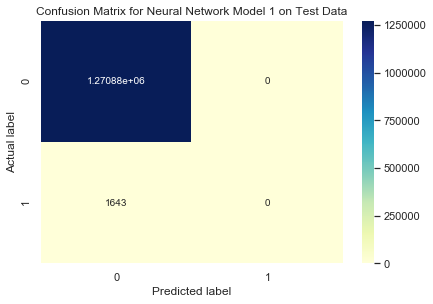

In [13]:
# Generate confusion matrix and classification report 
cnf_test_mod1 = metrics.confusion_matrix(y_test, y_pred_mod1)
clr_test_mod1 = metrics.classification_report(y_test, y_pred_mod1)

# Create Heatmap for Confusion Matrix 
sns.heatmap(cnf_test_mod1, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Neural Network Model 1 on Test Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [14]:
# Print classification report
print(clr_test_mod1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.00      0.00      0.00      1643

    accuracy                           1.00   1272524
   macro avg       0.50      0.50      0.50   1272524
weighted avg       1.00      1.00      1.00   1272524



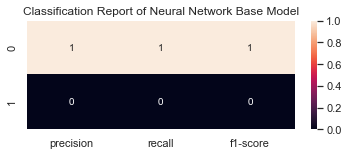

In [15]:
# Save classification report for presentation 
clf_report1 = metrics.classification_report(y_test, y_pred_mod1, output_dict=True)
df1 = pd.DataFrame(clf_report1).iloc[:-1, :2].T

fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(df1, annot=True)
plt.title("Classification Report of Neural Network Base Model")
ax.set_ylim(len(df1)+0, -0)
fig.savefig("nn_mod1", bbox_inches = 'tight')
plt.show()

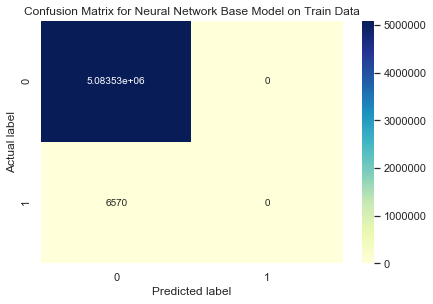

In [16]:
# Predict train data 
y_pred_mod1_train = classifier.predict(X_train_scaled)
y_pred_mod1_train = [0 if x < 0.5 else 1 for x in y_pred_mod1_train]

# Generate confusion matrix
cnf_train_mod1 = metrics.confusion_matrix(y_train, y_pred_mod1_train)

# Create Heatmap for Confusion Matrix 
sns.heatmap(cnf_train_mod1, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Neural Network Base Model on Train Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [17]:
# Generate classification report 
clr_train_mod1 = metrics.classification_report(y_train, y_pred_mod1_train)
print(clr_train_mod1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083526
           1       0.00      0.00      0.00      6570

    accuracy                           1.00   5090096
   macro avg       0.50      0.50      0.50   5090096
weighted avg       1.00      1.00      1.00   5090096



In [18]:
# Write model and model weights to disk
model_yaml = classifier.to_yaml()
with open("model_1.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

classifier.save_weights("model_1.h5")
print("Saved model to disk")

Saved model to disk


In [19]:
# Load model from disk
yaml_file = open('model_1.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = model_from_yaml(loaded_model_yaml)

# Load weights into new model
model.load_weights("model_1.h5")
print("Loaded model from disk")

Loaded model from disk


## Neural Network Model with Class Weighting 

In [20]:
from sklearn.utils.class_weight import compute_class_weight
# Calculate class weighting
weighting = compute_class_weight('balanced', [0,1], y)
print(weighting)

[  0.50064624 387.35054182]


In [21]:
# Define model
weights = {0:weighting[0], 1:weighting[1]}

# Initialize the ANN
model2 = Sequential()

# Add the input layer and the first hidden layer, followed by dropout layer for regularization 
model2.add(Dense(units = 64 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 19))
model2.add(Dropout(rate = 0.5))

# Add the second hidden layer, followed by dropout layer for regularization 
model2.add(Dense(units = 32, activation = 'relu'))
model2.add(Dropout(rate = 0.5))

# Add the output layer
model2.add(Dense(units = 1, activation = 'sigmoid'))

# Compile the ANN
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Get model summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1280      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Implement early stopping 
mc = ModelCheckpoint("best_wnn_model.h5", save_best_only = True, verbose = 1)
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 10, restore_best_weights = True)

In [23]:
# Fit the ANN to the training data 
wnn_hist = model2.fit(X_train_scaled, y_train, class_weight = weights, validation_split = 0.2, 
                          batch_size = 128, epochs = 30, verbose = 1, callbacks = [mc, es])

Train on 4072076 samples, validate on 1018020 samples
Epoch 1/20
4072076/4072076 [==============================] - 33s 8us/step - loss: 0.3354 - accuracy: 0.7951 - val_loss: 0.2462 - val_accuracy: 0.9734

Epoch 00001: val_loss improved from inf to 0.24616, saving model to best_wnn_model.h5
Epoch 2/20
4072076/4072076 [==============================] - 32s 8us/step - loss: 0.2746 - accuracy: 0.8949 - val_loss: 0.2057 - val_accuracy: 0.9518

Epoch 00002: val_loss improved from 0.24616 to 0.20572, saving model to best_wnn_model.h5
Epoch 3/20
4072076/4072076 [==============================] - 32s 8us/step - loss: 0.2580 - accuracy: 0.9074 - val_loss: 0.2278 - val_accuracy: 0.8267

Epoch 00003: val_loss did not improve from 0.20572
Epoch 4/20
4072076/4072076 [==============================] - 32s 8us/step - loss: 0.2676 - accuracy: 0.9109 - val_loss: 0.2022 - val_accuracy: 0.8974

Epoch 00004: val_loss improved from 0.20572 to 0.20223, saving model to best_wnn_model.h5
Epoch 5/20
4072076/40

In [24]:
model2.evaluate(X_test_scaled, y_test, batch_size = 128)

1272524/1272524 [==============================] - 3s 2us/step


[0.1547833386294205, 0.92274409532547]

In [25]:
# Predict test data 
y_pred_mod2 = model2.predict(X_test_scaled)
y_pred_mod2 = [0 if x < 0.5 else 1 for x in y_pred_mod2]

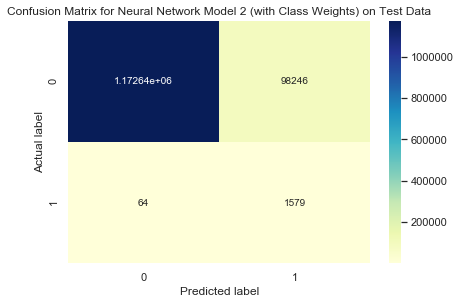

In [26]:
# Generate confusion matrix and classification report 
cnf_test_mod2 = metrics.confusion_matrix(y_test, y_pred_mod2)
clr_test_mod2 = metrics.classification_report(y_test, y_pred_mod2)

# Create Heatmap for Confusion Matrix 
sns.heatmap(cnf_test_mod2, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Neural Network Model 2 (with Class Weights) on Test Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [27]:
# Print classification report
print(clr_test_mod2)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96   1270881
           1       0.02      0.96      0.03      1643

    accuracy                           0.92   1272524
   macro avg       0.51      0.94      0.50   1272524
weighted avg       1.00      0.92      0.96   1272524



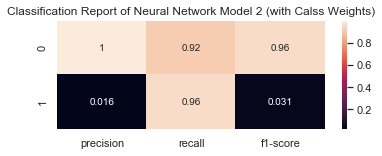

In [28]:
# Save classification report for presentation 
clf_report2 = metrics.classification_report(y_test, y_pred_mod2, output_dict=True)
df2 = pd.DataFrame(clf_report2).iloc[:-1, :2].T

fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(df2, annot=True)
plt.title("Classification Report of Neural Network Model 2 (with Calss Weights)")
ax.set_ylim(len(df2)+0, -0)
fig.savefig("nn_mod2", bbox_inches = 'tight')
plt.show()

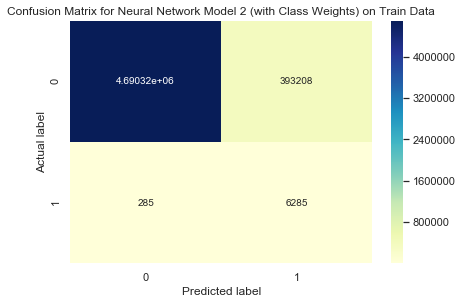

In [29]:
# Predict train data 
y_pred_mod2_train = model2.predict(X_train_scaled)
y_pred_mod2_train = [0 if x < 0.5 else 1 for x in y_pred_mod2_train]

# Generate confusion matrix
cnf_train_mod2 = metrics.confusion_matrix(y_train, y_pred_mod2_train)

# Create Heatmap for Confusion Matrix 
sns.heatmap(cnf_train_mod2, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Neural Network Model 2 (with Class Weights) on Train Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [30]:
# Generate classification report 
clr_train_mod2 = metrics.classification_report(y_train, y_pred_mod2_train)
print(clr_train_mod2)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96   5083526
           1       0.02      0.96      0.03      6570

    accuracy                           0.92   5090096
   macro avg       0.51      0.94      0.50   5090096
weighted avg       1.00      0.92      0.96   5090096



## With Oversampling 

In [31]:
# Load the train dataset after oversampling (normalized before ADASYN)
data = pd.read_csv("resampled_train_data.csv")
data.shape

(10166552, 20)

In [32]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,isFraud
0,0.000107,0.000743,0.000692,0.000000,0.000000,1.081718e-10,0.852023,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
1,0.000074,0.000000,0.000000,0.000000,0.000000,7.414681e-05,0.851989,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
2,0.003907,0.000000,0.000000,0.001376,0.002389,3.907294e-03,0.851912,0.300000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
3,0.000077,0.000000,0.000000,0.000000,0.000000,7.662373e-05,0.851991,0.300000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
4,0.002358,0.218942,0.267494,0.006848,0.006233,4.716714e-03,0.856807,0.166667,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


In [33]:
# Load the test dataset (already normalized via MinMaxScaler) 
test = pd.read_csv("test_data.csv")
test.shape

(1272524, 20)

In [34]:
# Create X and y object 
X_train2 = data.drop(['isFraud'], axis=1)
X_test2 = test.drop(['isFraud'], axis=1)
y_train2 = data['isFraud']
y_test2 = test['isFraud']

# Verify shape
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(10166552, 19)
(10166552,)
(1272524, 19)
(1272524,)


In [35]:
from collections import Counter
# Summarize class distribution
counter3 = Counter(y_train2)
print(counter3)

Counter({0: 5083526, 1: 5083026})


The oversampled train data have now achieved balance between the 2 classes.

In [36]:
counter4 = Counter(y_test2)
print(counter4)

Counter({0: 1270881, 1: 1643})


The test data was not oversampled and maintains the original imbalance between the 2 classes.

In [37]:
# Initialize the ANN
model3 = Sequential()

# Add the input layer and the first hidden layer, followed by dropout layer for regularization 
model3.add(Dense(units = 64 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 19))
model3.add(Dropout(rate = 0.5))

# Add the second hidden layer, followed by dropout layer for regularization 
model3.add(Dense(units = 32, activation = 'relu'))
model3.add(Dropout(rate = 0.5))

# Add the output layer
model3.add(Dense(units = 1, activation = 'sigmoid'))

# Compile the ANN
model3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Get model summary
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1280      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Implement early stopping 
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint("nn_oversampling.h5", save_best_only = True, verbose = 1)
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 10, restore_best_weights = True)

In [48]:
# Fit the ANN to the training data 
mod3_hist = model3.fit(X_train2, y_train2, validation_split = 0.2, 
                      batch_size = 2048, epochs = 50, verbose = 1, callbacks = [mc, es]).history

Train on 8133241 samples, validate on 2033311 samples
Epoch 1/50
8133241/8133241 [==============================] - 22s 3us/step - loss: 0.1346 - accuracy: 0.9529 - val_loss: 0.2074 - val_accuracy: 0.9845

Epoch 00001: val_loss did not improve from 0.13723
Epoch 2/50
8133241/8133241 [==============================] - 19s 2us/step - loss: 0.1098 - accuracy: 0.9606 - val_loss: 0.2510 - val_accuracy: 0.9841

Epoch 00002: val_loss did not improve from 0.13723
Epoch 3/50
8133241/8133241 [==============================] - 18s 2us/step - loss: 0.1052 - accuracy: 0.9634 - val_loss: 0.3657 - val_accuracy: 0.9840

Epoch 00003: val_loss did not improve from 0.13723
Epoch 4/50
8133241/8133241 [==============================] - 18s 2us/step - loss: 0.1037 - accuracy: 0.9635 - val_loss: 0.4436 - val_accuracy: 0.9835

Epoch 00004: val_loss did not improve from 0.13723
Epoch 5/50
8133241/8133241 [==============================] - 18s 2us/step - loss: 0.1067 - accuracy: 0.9597 - val_loss: 0.4985 - val_

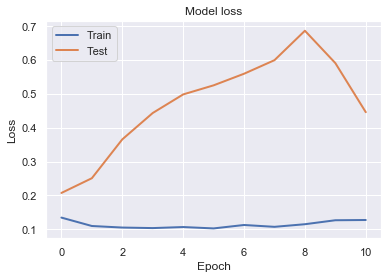

In [50]:
# model loss
plt.plot(mod3_hist['loss'], linewidth=2, label='Train')
plt.plot(mod3_hist['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper left')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [40]:
model3.evaluate(X_test2, y_test2, batch_size = 2048)

1272524/1272524 [==============================] - 1s 1us/step


[0.09873954668125338, 0.9515639543533325]

In [41]:
# Predict test data 
y_pred_mod3 = model3.predict(X_test2)
y_pred_mod3 = [0 if x < 0.5 else 1 for x in y_pred_mod3]

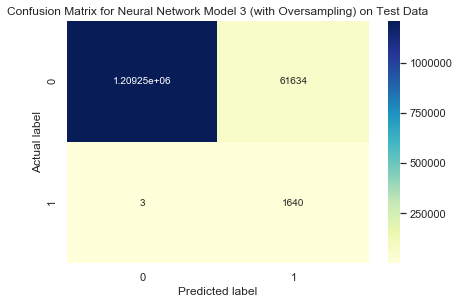

In [42]:
# Generate confusion matrix and classification report 
cnf_test_mod3 = metrics.confusion_matrix(y_test2, y_pred_mod3)
clr_test_mod3 = metrics.classification_report(y_test2, y_pred_mod3)

# Create Heatmap for Confusion Matrix 
sns.heatmap(cnf_test_mod3, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Neural Network Model 3 (with Oversampling) on Test Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.savefig("cnf_nn3", bbox_inches = 'tight')
plt.show()

In [43]:
# Print classification report
print(clr_test_mod3)

              precision    recall  f1-score   support

           0       1.00      0.95      0.98   1270881
           1       0.03      1.00      0.05      1643

    accuracy                           0.95   1272524
   macro avg       0.51      0.97      0.51   1272524
weighted avg       1.00      0.95      0.97   1272524



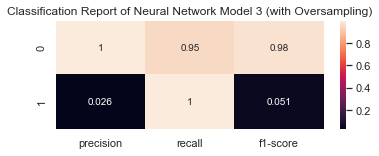

In [44]:
# Save classification report for presentation 
clf_report3 = metrics.classification_report(y_test2, y_pred_mod3, output_dict=True)
df3 = pd.DataFrame(clf_report3).iloc[:-1, :2].T

fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(df3, annot=True)
plt.title("Classification Report of Neural Network Model 3 (with Oversampling)")
ax.set_ylim(len(df3)+0, -0)
fig.savefig("nn_mod3", bbox_inches = 'tight')
plt.show()

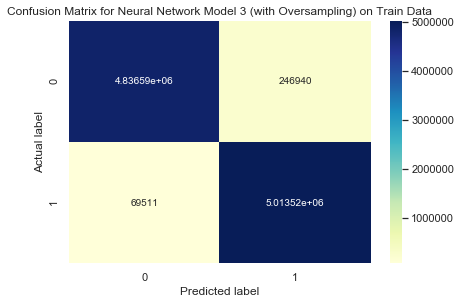

In [45]:
# Predict train data 
y_pred_mod3_train = model3.predict(X_train2)
y_pred_mod3_train = [0 if x < 0.5 else 1 for x in y_pred_mod3_train]

# Generate confusion matrix
cnf_train_mod3 = metrics.confusion_matrix(y_train2, y_pred_mod3_train)

# Create Heatmap for Confusion Matrix 
sns.heatmap(cnf_train_mod3, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Neural Network Model 3 (with Oversampling) on Train Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [46]:
# Generate classification report 
clr_train_mod3 = metrics.classification_report(y_train2, y_pred_mod3_train)
print(clr_train_mod3)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97   5083526
           1       0.95      0.99      0.97   5083026

    accuracy                           0.97  10166552
   macro avg       0.97      0.97      0.97  10166552
weighted avg       0.97      0.97      0.97  10166552



From the comparison of accuracy and the classification reports between the train and test data , we can see there's no overfitting. We have almost perfect recall on the test data, while the low precision and f1-score of class 1 is due to the high accuracy in identifying the fraudulent transactions. 